# Time series anomaly detection using Chronos fundamental model

Based on https://github.com/amazon-science/chronos-forecasting

In [1]:
# !pip install chronos-forecasting

In [2]:
import matplotlib.pyplot as plt
import pandas as pd  # requires: pip install pandas
import numpy as np
import torch
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline

import sys
sys.path.append("../scripts")
import utils

from tqdm import tqdm

# Data

In [3]:
def generate_data(n=1000, T=12, n_anomalies=0, max_anomaly_size=5, n_normal_start=100):
    t = np.arange(n)
    t0 = np.random.randint(0, T)
    x1 = np.sin(2 * np.pi / T * (t + t0))
    x2 = np.cos(2 * np.pi / T * (t + t0))
    x = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis=1)
    y = np.zeros(n)

    for k in range(n_anomalies):
        i_start = np.random.randint(n_normal_start, n)
        i_end = i_start + np.random.randint(0, max_anomaly_size)
        level = np.random.rand()
        x[i_start:i_end] = level
        y[i_start:i_end] = 1

    return x, y

In [4]:
X_normal, y_normal = generate_data(n=500, n_anomalies=0)
X_attack, y_attack = generate_data(n=500, n_anomalies=10)

In [5]:
X_normal.shape, y_normal.shape

((500, 2), (500,))

In [6]:
X_attack.shape, y_attack.shape

((500, 2), (500,))

# Data visualization

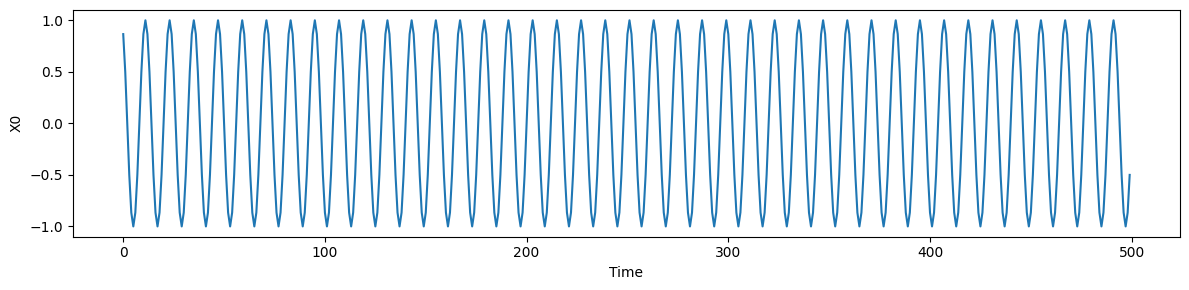

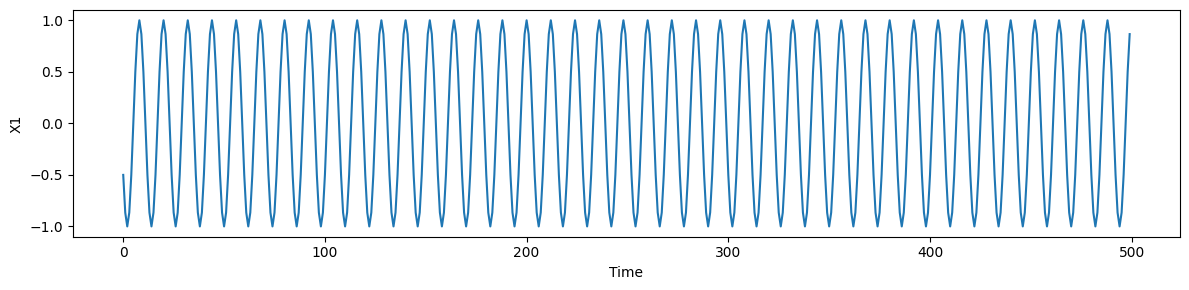

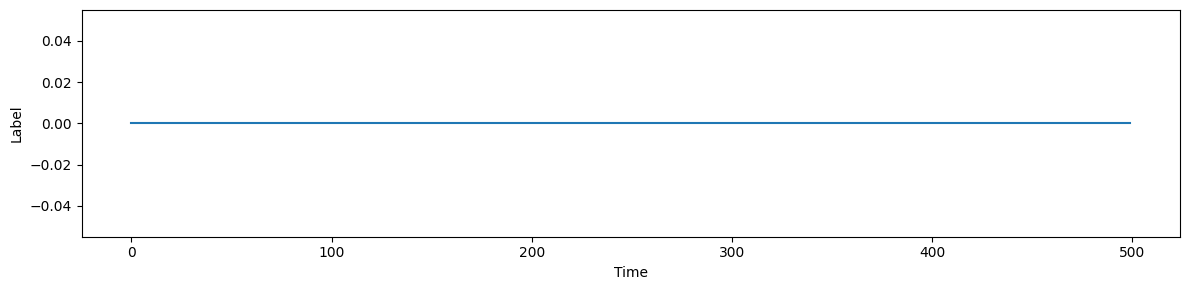

In [7]:
# normal sample

for i in range(X_normal.shape[1]):
    plt.figure(figsize=(12, 3))
    plt.plot(X_normal[:, i])
    plt.xlabel('Time')
    plt.ylabel('X'+str(i))
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 3))
plt.plot(y_normal)
plt.xlabel('Time')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

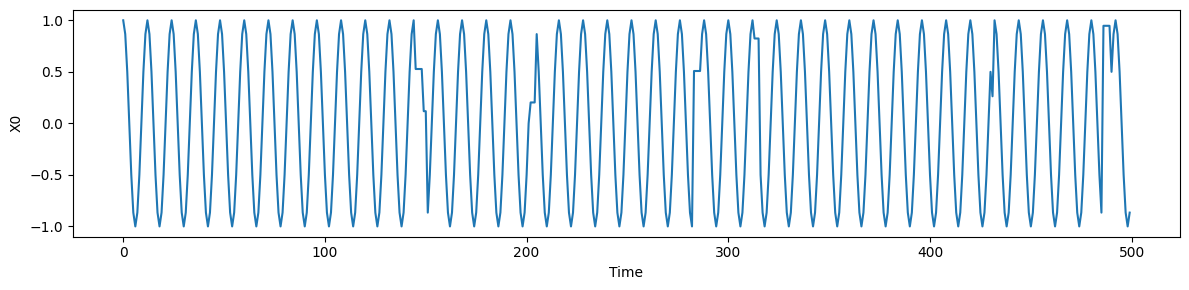

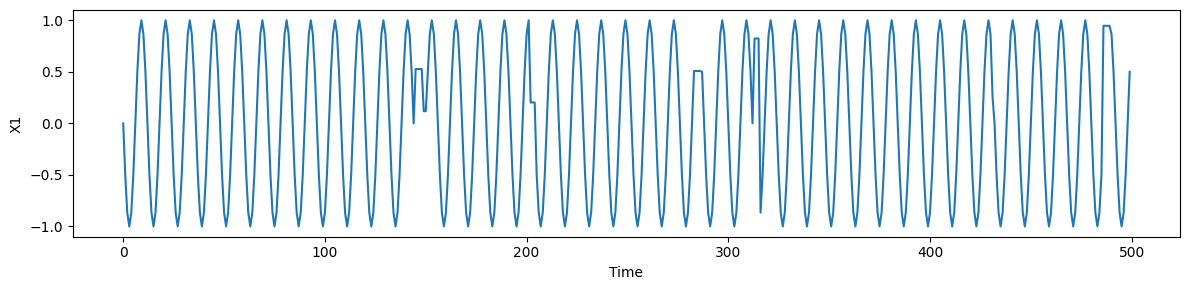

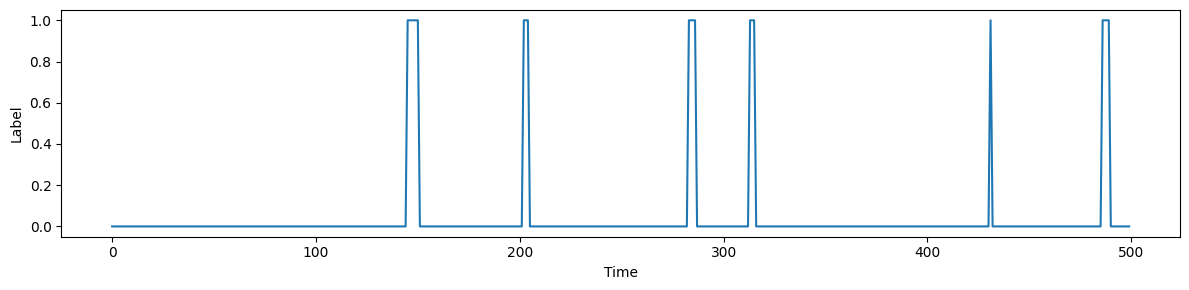

In [8]:
# sample with attacks

for i in range(X_attack.shape[1]):
    plt.figure(figsize=(12, 3))
    plt.plot(X_attack[:, i])
    plt.xlabel('Time')
    plt.ylabel('X'+str(i))
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 3))
plt.plot(y_attack)
plt.xlabel('Time')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

# Model's setup

In [9]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cpu",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

In [10]:
# other options
print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

# Anomaly Detection

In [11]:
context_len = 40
prediction_len = 5
step = 5

In [12]:
X_pred = np.zeros_like(X_attack)
anomaly_scores = np.zeros(len(X_attack))
counts = np.zeros(len(X_attack))

for start in tqdm(np.arange(0, len(X_attack), step)):
    
    #print(start)
    if (start+context_len+prediction_len) >= len(X_attack):
        start = len(X_attack) - context_len - prediction_len
    
    # get samples for context and target
    ax_context = X_attack[start:start+context_len]
    ax_target = X_attack[start+context_len:start+context_len+prediction_len]
    
    # make predictions for target
    ax_pred_quantiles, ax_pred_mean = pipeline.predict_quantiles(
        context=torch.tensor(ax_context.T),
        prediction_length=prediction_len,
        quantile_levels=[0.5],
    )
    
    # prediction error as anomaly score
    ax_score = ((ax_target - ax_pred_mean.numpy().T)**2).mean(axis=1)
    
    # collect target info
    X_pred[start+context_len:start+context_len+prediction_len] += ax_pred_mean.numpy().T
    anomaly_scores[start+context_len:start+context_len+prediction_len] += ax_score
    counts[start+context_len:start+context_len+prediction_len] += 1
    
    if (start+context_len+prediction_len) >= len(X_attack):
        break

# get averages
X_pred = X_pred / (counts.reshape(-1, 1) + 10**-6)
anomaly_scores = anomaly_scores / (counts + 10**-6)

  0%|          | 0/100 [00:00<?, ?it/s]/home/mhushchyn/.conda/envs/fundamental_ts/lib/python3.11/site-packages/chronos/chronos.py:189: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  torch.bucketize(
 91%|█████████ | 91/100 [01:02<00:06,  1.45it/s]


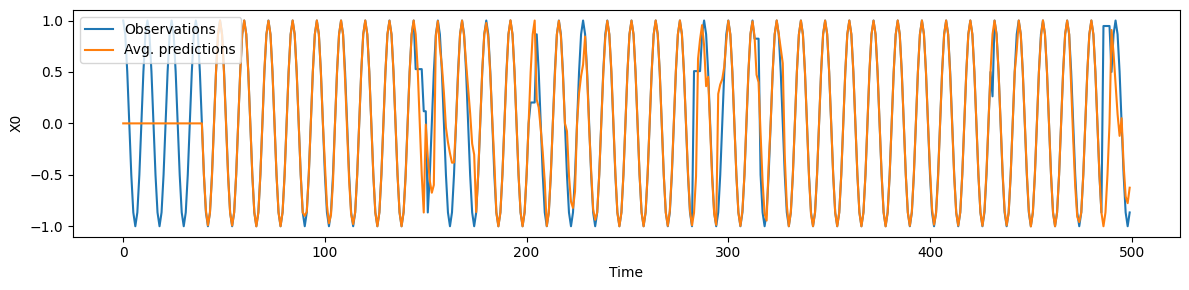

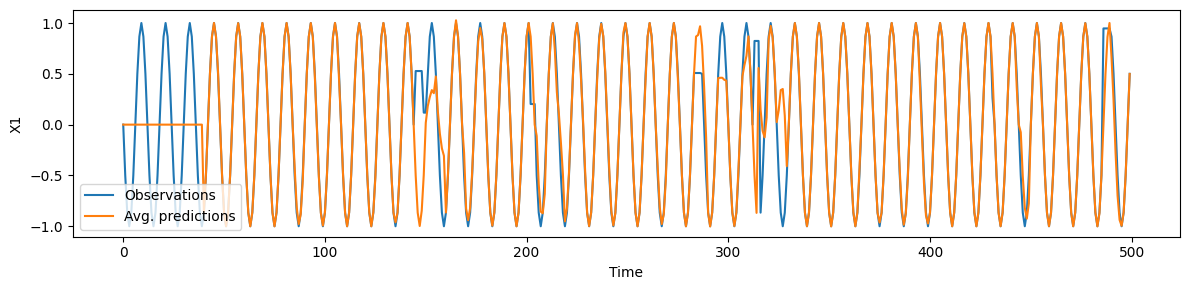

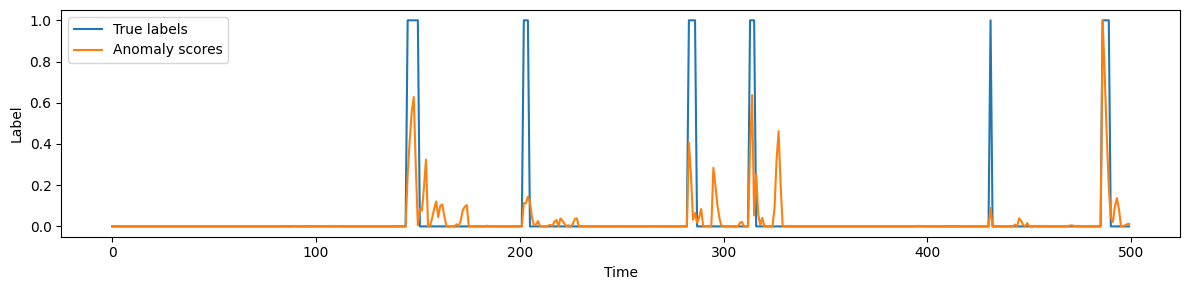

In [13]:
# sample with attacks

for i in range(X_attack.shape[1]):
    plt.figure(figsize=(12, 3))
    plt.plot(X_attack[:, i], label='Observations')
    plt.plot(X_pred[:, i], label='Avg. predictions')
    plt.xlabel('Time')
    plt.ylabel('X'+str(i))
    plt.tight_layout()
    plt.legend()
    plt.show()

plt.figure(figsize=(12, 3))
plt.plot(y_attack, label='True labels')
plt.plot(anomaly_scores / anomaly_scores.max(), label='Anomaly scores')
plt.xlabel('Time')
plt.ylabel('Label')
plt.tight_layout()
plt.legend()
plt.show()

# Quality metrics

In [14]:
utils.anomalybert_quality_metrics(y_attack[context_len:], anomaly_scores[context_len:])

Best F1-score without point adjustment
anomaly rate: 0.057 | precision: 0.59259 | recall: 0.76190 | F1-score: 0.66667 | ROC AUC: 0.97668

Best F1-score with point adjustment
anomaly rate: 0.018 | precision: 0.94444 | recall: 0.80952 | F1-score: 0.87179 | ROC AUC: 0.97668



(0.9444444444444444,
 0.8095238095238095,
 0.8717948717948718,
 0.9766785985464801)